In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch

## Data Cleaning & Preprocessing

In [2]:
# Load the data into a DataFrame
dateformat_str = "%Y-%m-%d %H:%M"
data = pd.read_csv('data/tsla_2019_2022.csv', na_values=[' '], skipinitialspace=True, date_format=dateformat_str, parse_dates=True) # some missing values in the dataset are given as an empty space

# Remove leading and trailing whitespace and square brackets from column names
data.columns = data.columns.str.strip('data.columns.str.strip(" []")')

# Display the column names
print("Column names:", data.columns)

print("Shape of data:", data.shape)

Column names: Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')
Shape of data: (2659259, 33)


In [3]:
# Convert cols with date/time to datetime data type
data["QUOTE_READTIME"] = pd.to_datetime(data["QUOTE_READTIME"], format="%Y-%m-%d %H:%M", exact=True)
data["QUOTE_DATE"] = pd.to_datetime(data["QUOTE_DATE"], format="%Y-%m-%d", exact=True)
data["EXPIRE_DATE"] = pd.to_datetime(data["EXPIRE_DATE"], format="%Y-%m-%d", exact=True)
# can use .dt.tz_localize(tz="US/Eastern") to set to Eastern time then convert to local timezone if we want to
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2659259 entries, 0 to 2659258
Data columns (total 33 columns):
 #   Column               Dtype         
---  ------               -----         
 0   QUOTE_UNIXTIME       int64         
 1   QUOTE_READTIME       datetime64[ns]
 2   QUOTE_DATE           datetime64[ns]
 3   QUOTE_TIME_HOURS     float64       
 4   UNDERLYING_LAST      float64       
 5   EXPIRE_DATE          datetime64[ns]
 6   EXPIRE_UNIX          int64         
 7   DTE                  float64       
 8   C_DELTA              float64       
 9   C_GAMMA              float64       
 10  C_VEGA               float64       
 11  C_THETA              float64       
 12  C_RHO                float64       
 13  C_IV                 float64       
 14  C_VOLUME             float64       
 15  C_LAST               float64       
 16  C_SIZE               object        
 17  C_BID                float64       
 18  C_ASK                float64       
 19  STRIKE               

In [4]:
print(data[data.isnull().any(axis=1)].shape)
# 897680/2659259 = 0.337 of rows have some missing value in some cols, so we shouldn't drop them since its a large portion of the dataset

(897680, 33)


In [5]:
# Display the first few rows of the DataFrame to ensure it loaded correctly
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,0.01,-0.00071,0.00003,0.00046,-0.00975,0.00000,2.22548,147.0,104.0,0.444
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,0.02,-0.00109,0.00009,0.00058,-0.01010,-0.00001,2.08349,12.0,99.0,0.423
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,0.02,-0.00122,0.00012,0.00113,-0.01435,0.00000,2.02359,15.0,94.0,0.402
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,0.01,-0.00134,0.00009,0.00139,-0.01465,0.00000,1.89504,0.0,89.0,0.380
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,0.01,-0.00176,0.00008,0.00105,-0.01467,0.00000,1.76812,91.0,84.0,0.359


### Realized Volatility

We need to calculate realized/historical volatility as that is the real volatility we want to predict. Implied volatility is calculated through solving for volatility using options price and other inputs at a given time using Black-Scholes and other models.

In [6]:
# extract underlying price for each day
underlying = data[['QUOTE_DATE', 'UNDERLYING_LAST']]
underlying = underlying.drop_duplicates(subset=['QUOTE_DATE'])

# Verify there is only one price per date
if underlying['QUOTE_DATE'].duplicated().any():
    print("Warning: There are multiple prices for at least one date.")
else:
    print("Each date has a unique price.")

# Check if the DataFrame is sorted by 'QUOTE_DATE'
if underlying['QUOTE_DATE'].is_monotonic_increasing:
    print("The DataFrame is sorted by date.")
else:
    # underlying['Prev_QUOTE_DATE'] = underlying['QUOTE_DATE'].shift(1)
    # unsorted_rows = underlying[underlying['QUOTE_DATE'] < underlying['Prev_QUOTE_DATE']]
    # print("Adjacent rows that are not sorted:")
    # print(unsorted_rows[['Prev_QUOTE_DATE', 'QUOTE_DATE']])
    print("The DataFrame is not sorted by date. Sorting now.")
    underlying = underlying.sort_values(by='QUOTE_DATE')



# calculate log returns and realized volatility of the underlying
window_size = 10  # trading days in rolling window
dpy = 252  # trading days per year
ann_factor = dpy / window_size
# https://stackoverflow.com/questions/43284304/how-to-compute-volatility-standard-deviation-in-rolling-window-in-pandas
underlying['LOG_RETURNS'] = np.log(underlying['UNDERLYING_LAST']) - np.log(underlying['UNDERLYING_LAST'].shift(1))
underlying['REALIZED_VOL'] = np.sqrt(underlying['LOG_RETURNS'].rolling(window=window_size).var() * ann_factor)

Each date has a unique price.
The DataFrame is not sorted by date. Sorting now.


In [7]:
underlying['REALIZED_VOL'].unique()

array([       nan, 0.15469482, 0.13626489, ..., 0.25059357, 0.30896178,
       0.31070019])

In [8]:
# Join the 'log_returns' and 'realized_vol' columns back with the full options dataframe
data = pd.merge(data, underlying[['QUOTE_DATE', 'LOG_RETURNS', 'REALIZED_VOL']], on='QUOTE_DATE', how='left')
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,LOG_RETURNS,REALIZED_VOL
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,0.00003,0.00046,-0.00975,0.00000,2.22548,147.0,104.0,0.444,-0.01993,0.124
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,0.00009,0.00058,-0.01010,-0.00001,2.08349,12.0,99.0,0.423,-0.01993,0.124
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,0.00012,0.00113,-0.01435,0.00000,2.02359,15.0,94.0,0.402,-0.01993,0.124
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,0.00009,0.00139,-0.01465,0.00000,1.89504,0.0,89.0,0.380,-0.01993,0.124
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,0.00008,0.00105,-0.01467,0.00000,1.76812,91.0,84.0,0.359,-0.01993,0.124


In [9]:
data['C_MID'] = (data['C_BID'] + data['C_ASK']) / 2
data['P_MID'] = (data['P_BID'] + data['P_ASK']) / 2
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,LOG_RETURNS,REALIZED_VOL,C_MID,P_MID
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,-0.00975,0.00000,2.22548,147.0,104.0,0.444,-0.01993,0.124,104.400,0.010
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,-0.01010,-0.00001,2.08349,12.0,99.0,0.423,-0.01993,0.124,99.400,0.015
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,-0.01435,0.00000,2.02359,15.0,94.0,0.402,-0.01993,0.124,94.325,0.020
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,-0.01465,0.00000,1.89504,0.0,89.0,0.380,-0.01993,0.124,89.125,0.020
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,-0.01467,0.00000,1.76812,91.0,84.0,0.359,-0.01993,0.124,84.070,0.015


In [10]:
data['REALIZED_VOL'].unique()

array([0.12400049, 0.1544875 , 0.17575756, ..., 0.11863259, 0.12330856,
       0.12250695])

In [11]:
# Split the data into training and testing sets (assuming the data is already sorted by date)
split_index = int(len(data) * 0.75) # may need to adjust to increase it
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Verify the shape of the training and testing sets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (1994444, 37)
Testing data shape: (664815, 37)


Now, I want to parse for ATM strikes. To do this, I will only be looking at options where the delta is between 45-55, or -45 to -55.

In [12]:
# Select relevant columns
# selected_columns = ['QUOTE_DATE', 'DTE', 'C_DELTA', 'C_IV', 'STRIKE', 'P_DELTA', 'P_IV', 'UNDERLYING_LAST', 'C_MID', 'P_MID', 'REALIZED_VOL']
selected_features = ['QUOTE_DATE', 'DTE', 'UNDERLYING_LAST', 'STRIKE', 'C_MID', 'REALIZED_VOL']

# Filter data to include only ATM options (where delta is closest to 0.5)
# Ensure column names match exactly what's in the DataFrame
atm_options = data[(data['C_DELTA'] >= 0.45) & (data['C_DELTA'] <= 0.55) & (data['P_DELTA'] >= -0.55) & (data['P_DELTA'] <= -0.45)]

# Display the first few rows of the filtered DataFrame
print("Number of rows in atm_options:", len(atm_options))
print(atm_options.head())
print(atm_options.tail())

Number of rows in atm_options: 119965
     QUOTE_UNIXTIME      QUOTE_READTIME QUOTE_DATE  QUOTE_TIME_HOURS  \
27       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
98       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
99       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
181      1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
275      1556740800 2019-05-01 16:00:00 2019-05-01              16.0   

     UNDERLYING_LAST EXPIRE_DATE  EXPIRE_UNIX   DTE  C_DELTA  C_GAMMA  ...  \
27            233.98  2019-05-03   1556913600   2.0  0.46754  0.04011  ...   
98            233.98  2019-05-10   1557518400   9.0  0.54695  0.01962  ...   
99            233.98  2019-05-10   1557518400   9.0  0.49653  0.02035  ...   
181           233.98  2019-05-17   1558123200  16.0  0.50681  0.01542  ...   
275           233.98  2019-05-24   1558728000  23.0  0.54600  0.01265  ...   

     P_THETA    P_RHO     P_IV  P_VOLUME  STRIKE_DISTANCE  \

In [13]:
# some rows have missing values for C_VOLUME and P_VOLUME
# Count the number of rows where 'P_VOLUME' is exactly zero
zero_count = (atm_options['REALIZED_VOL'] == 0).sum()

# Count the number of rows where 'P_VOLUME' is missing (NaN)
missing_count = atm_options['REALIZED_VOL'].isna().sum()

print(f"Number of rows where 'REALIZED_VOL' is zero: {zero_count}")
print(f"Number of rows where 'REALIZED_VOL' is missing: {missing_count}")

# lets set them to zero for now (may need to find some other way to deal with this)
# data['C_VOLUME'].fillna(0, inplace=True)
# data['P_VOLUME'].fillna(0, inplace=True)
atm_options = atm_options.dropna() # TODO: only drop rows where cols we care about are missing

Number of rows where 'REALIZED_VOL' is zero: 0
Number of rows where 'REALIZED_VOL' is missing: 733


In [14]:
atm_options['REALIZED_VOL'].shape

(98976,)

### Data Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# TODO: will need to train once for PUTs and once for CALLs, let's do CALLS first.
selected_features = ['DTE', 'UNDERLYING_LAST', 'STRIKE', 'C_MID', 'REALIZED_VOL']
output_feature_index = selected_features.index('REALIZED_VOL')  # Get index of REALIZED_VOL

print("Shape of atm_options:", atm_options.shape)
print("Selected features:", selected_features)
print("Number of rows in atm_options after filtering:", len(atm_options))

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(atm_options[selected_features])

# Extract dates for indexing in plots
dates = atm_options['QUOTE_UNIXTIME'].values

# Organize the data into sequences with a variable length
X_train = []
y_train = []
dates_train = []
sequence_length = window_size


for i in range(len(scaled_data) - sequence_length):
    X_train.append(scaled_data[i:i+sequence_length])  # Skip date in features
    y_train.append(scaled_data[i + sequence_length, output_feature_index])
    dates_train.append(dates[i + sequence_length])  # Save date for each y value

# Convert list of numpy arrays to numpy arrays and then to tensors
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
dates_train_np = np.array(dates_train)  # Assuming dates are already in a suitable format

X = torch.tensor(X_train_np, dtype=torch.float32)
y = torch.tensor(y_train_np, dtype=torch.float32)
# Print the shape of X and y to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of atm_options: (98976, 37)
Selected features: ['DTE', 'UNDERLYING_LAST', 'STRIKE', 'C_MID', 'REALIZED_VOL']
Number of rows in atm_options after filtering: 98976
Shape of X: torch.Size([98966, 10, 5])
Shape of y: torch.Size([98966])


## Neural Network Implementation
Will need to train one model for calls and one for puts
Features:
- historical volatility
- log returns (?)
- underlying price
- option price (bid/ask)
- strike price
- DTE (days till expiration)
- volume (?)
- delta (?)

Loss function: MSE

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class VolNet(nn.Module):
    def __init__(self, num_inputs):
        super(VolNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_layers = 2
        self.hidden_size = 32
        self.num_outputs = 1
        
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True) # up to 3 layers for LSTM
        self.dense = nn.Linear(in_features=self.hidden_size, out_features=self.num_outputs) # fully-connected layer
        
        # self.last_h = self.initHidden()
        # self.last_c = self.initHidden()
        
    def forward(self, x):
        # x should be of shape (batch, sequence, features)
        batch_size = x.shape[0]
        lstm_out, (hn, cn) = self.lstm(x, (self.initHidden(batch_size), self.initHidden(batch_size)))
        # self.last_h, self.last_c = hn, cn
        last_time_step_out = lstm_out[:, -1, :]  # Use the output from the last time step
        return self.dense(last_time_step_out)
    
    def initHidden(self, batch_size):
        if not batch_size:
            batch_size = self.hidden_size * self.num_layers
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
model = VolNet(num_inputs=len(selected_features)) # Adjust num_inputs based on your feature count

In [20]:
from torch.utils.data import TensorDataset, DataLoader


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
batch_size = 128

# Training Loop
num_epochs = 20

training_set = TensorDataset(X, y)
train_loader = DataLoader(training_set, batch_size=128, shuffle=True)

# Variables to store performance metrics
predictions, actuals, times = [], [], []

# Training loop
for epoch in range(num_epochs):  # Assuming num_epochs is 20
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Make predictions
        outputs = model(inputs)
        predictions.extend(outputs.detach().numpy().flatten())  # Store predictions
        actuals.extend(labels.numpy())  # Store actual values
        total_loss += criterion(outputs, labels.unsqueeze(1)).item()

        # Backpropagate and update model
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.9f}')

# Convert lists to numpy arrays for easier plotting
predictions = np.array(predictions)
actuals = np.array(actuals)


Epoch 1, Loss: 0.000040467
Epoch 2, Loss: 0.000043299
Epoch 3, Loss: 0.000042166
Epoch 4, Loss: 0.000041186
Epoch 5, Loss: 0.000042482
Epoch 6, Loss: 0.000040966
Epoch 7, Loss: 0.000041848
Epoch 8, Loss: 0.000041353
Epoch 9, Loss: 0.000041921
Epoch 10, Loss: 0.000040801
Epoch 11, Loss: 0.000040574
Epoch 12, Loss: 0.000040969
Epoch 13, Loss: 0.000040985
Epoch 14, Loss: 0.000040828
Epoch 15, Loss: 0.000041252
Epoch 16, Loss: 0.000040660
Epoch 17, Loss: 0.000041030
Epoch 18, Loss: 0.000039559
Epoch 19, Loss: 0.000040668
Epoch 20, Loss: 0.000041131


ValueError: x and y must have same first dimension, but have shapes (98957,) and (1979320,)

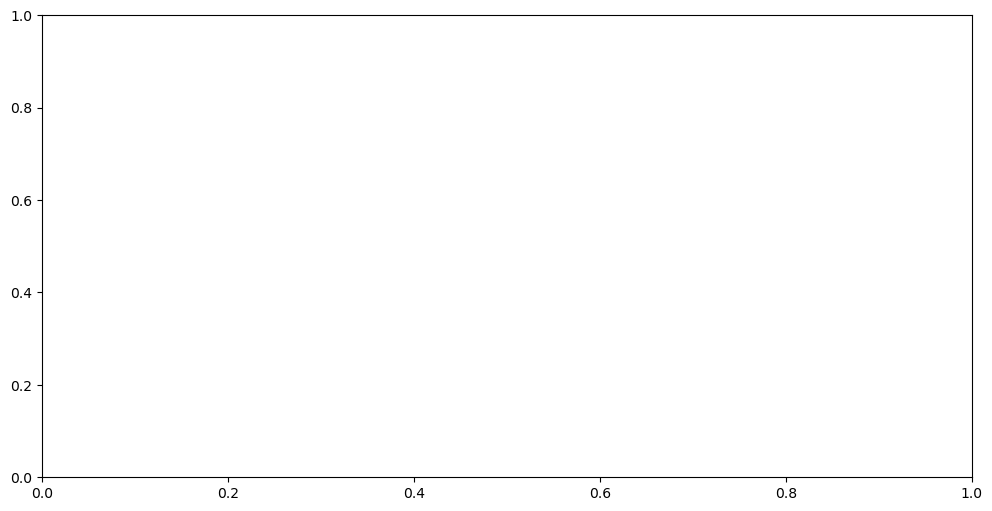

In [23]:
# Assuming dates_train_np holds the timestamps and you have a window_size (or sequence_length)
adjusted_dates = dates_train_np[sequence_length - 1:]  # Skip the first sequence_length - 1 timestamps

# Plotting actual vs predicted realized volatility
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, actuals, label='Actual Realized Volatility', marker='o', linestyle='-')
plt.plot(adjusted_dates, predictions, label='Predicted Realized Volatility', marker='x', linestyle='--')
plt.title('Actual vs Predicted Realized Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Realized Volatility')
plt.legend()
plt.gcf().autofmt_xdate()  # Improve formatting of date labels
plt.show()

In [25]:
 actuals.shape

(1979320,)